### Dependencies

In [3]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re
import palettable

sys.path.append('..')
from GIR import *
## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Pandas options setup

pd.set_option('display.max_columns', 100)
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Part I: constraining the ensemble
This section computes the probability of selecting each ensemble member based on a kernel density estimate of the GWI ensemble computed in "GWI_generation"

**Skip to part II if using previously calculated ensemble member selection probabilities**

### Get GWI ensemble

In [2]:
temp_attr_ant = np.load('../Parameter_Sets/NROY_GWI_informed/GWI_distribution/ant_level_attr.npy',mmap_mode='r')
temp_attr_nat = np.load('../Parameter_Sets/NROY_GWI_informed/GWI_distribution/nat_level_attr.npy',mmap_mode='r')

temp_rate_attr_ant = np.load('../Parameter_Sets/NROY_GWI_informed/GWI_distribution/ant_rate_attr.npy',mmap_mode='r')
temp_rate_attr_nat = np.load('../Parameter_Sets/NROY_GWI_informed/GWI_distribution/nat_rate_attr.npy',mmap_mode='r')

In [7]:
# dimensions = ['obsv','IV','forc','response']

# for i,dim in enumerate(dimensions):
#     mean_dims = [0,1,2,3]
#     del mean_dims[i]
#     print(dim+':')
#     print('level',np.quantile(np.mean(temp_attr_ant,axis=tuple(mean_dims)),[0.05,0.17,0.5,0.83,0.95])-np.quantile(np.mean(temp_attr_ant,axis=tuple(mean_dims)),0.5))
#     print('rate',np.quantile(np.mean(temp_rate_attr_ant,axis=tuple(mean_dims)),[0.05,0.17,0.5,0.83,0.95])-np.quantile(np.mean(temp_rate_attr_ant,axis=tuple(mean_dims)),0.5),'\n')

obsv:
level [-0.04629545 -0.03710015  0.          0.03344596  0.05243133]
rate [-0.00106815 -0.00083161  0.          0.00077841  0.00122038] 

IV:
level [-0.14165507 -0.07758401  0.          0.07331608  0.17277175]
rate [-0.00329519 -0.00187136  0.          0.0017373   0.00390572] 

forc:
level [-0.16335298 -0.03810849  0.          0.02511343  0.03940562]
rate [-0.00656919 -0.00431014  0.          0.00566385  0.00906548] 

response:
level [-0.03650219 -0.01341715  0.          0.00419876  0.00478591]
rate [-0.00074692 -0.00034073  0.          0.00035958  0.00048832] 



### GWI statistics

In [3]:
print('anthropogenic warming')
print(np.quantile(temp_attr_ant,[0.05,0.17,0.5,0.83,0.95]))
print(np.quantile(temp_rate_attr_ant,[0.05,0.17,0.5,0.83,0.95]))

anthropogenic warming
[0.78903063 0.92848845 1.03579316 1.14033439 1.24825906]
[0.01616146 0.01881652 0.02353615 0.02955162 0.03401886]


In [4]:
print('natural warming')
print(np.quantile(temp_attr_nat,[0.05,0.17,0.5,0.83,0.95]))
print(np.quantile(temp_rate_attr_nat,[0.05,0.17,0.5,0.83,0.95]))

natural warming
[0.00222781 0.0102855  0.02497425 0.05336744 0.0954213 ]
[0.00016932 0.00146485 0.00363982 0.0070378  0.01107023]


In [3]:
print('total warming')
print(np.quantile(temp_attr_ant+temp_attr_nat,[0.05,0.17,0.5,0.83,0.95]))
print(np.quantile(temp_rate_attr_ant+temp_rate_attr_nat,[0.05,0.17,0.5,0.83,0.95]))

total warming
[0.8370083  0.96595317 1.06849901 1.17089922 1.26950145]
[0.01952523 0.02256905 0.02777366 0.03427919 0.03977196]


In [4]:
print('Complete GWI ensemble size:',int(temp_attr_ant.size//1e6),'million')
print('Complete GWI ensemble dimensions:',temp_attr_ant.shape,'/ (observational, IV, forc, response)')

Complete GWI ensemble size: 1836 million
Complete GWI ensemble dimensions: (100, 102, 10000, 18) / (observational, IV, forc, response)


Text(0, 0.5, 'rate of temperature change over 2010-2014 / K decade$^{-1}$')

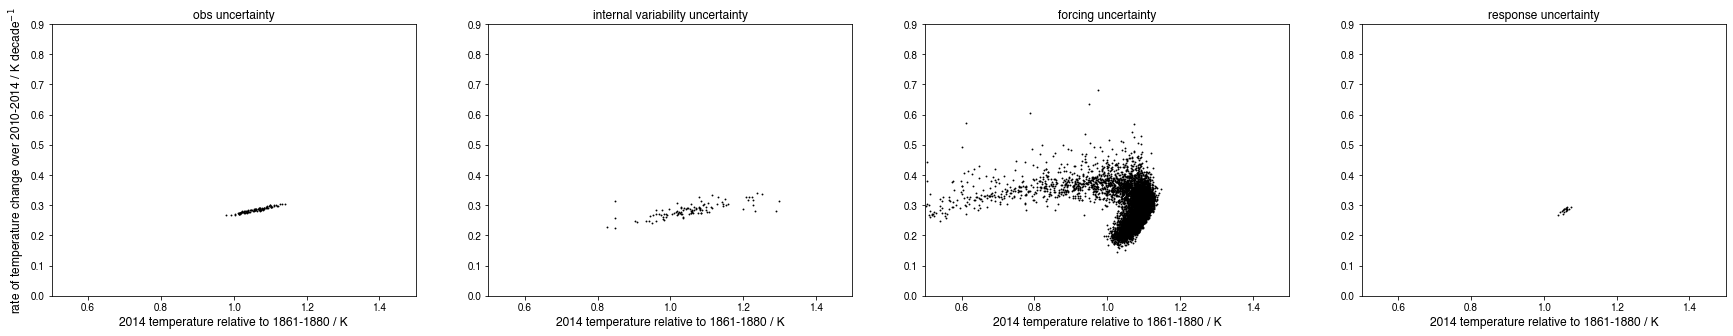

In [5]:
fig,ax=plt.subplots(1,4,figsize=(30,5))
# ax[0].hist2d((temp_attr_ant_and_iv+temp_attr_nat_and_iv).flatten(),10*(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv).flatten(),bins=500,cmap='binary',density=True)

for i,source in enumerate(['obs','internal variability','forcing','response']):
    print('computing '+source,end='\r')
    axes = tuple((np.arange(1,4)+i)%4)
    ax[i].scatter(temp_attr_ant.mean(axis=axes)+temp_attr_nat.mean(axis=axes),10*(temp_rate_attr_ant.mean(axis=axes)+temp_rate_attr_nat.mean(axis=axes)),color='k',marker='.',s=3)
    ax[i].set_title(source+' uncertainty')
    
[a.set_xlim(0.5,1.5) for a in ax]
[a.set_ylim(0.0,0.9) for a in ax]
[a.set_xlabel('2014 temperature relative to 1861-1880 / K',fontsize=12) for a in ax]
ax[0].set_ylabel('rate of temperature change over 2010-2014 / K decade$^{-1}$',fontsize=12)
# ax[0].set_title('FULL uncertainty',fontsize=12)

#### subsample for analysis

In [8]:
## basic random sampling
subsample = np.random.choice(18*100*10000*102,int(2e6),replace=False)
GWI_level_subsample = (temp_attr_ant+temp_attr_nat).ravel()[subsample]
GWI_rate_subsample = (temp_rate_attr_ant+temp_rate_attr_nat).ravel()[subsample]

In [7]:
print(np.quantile(GWI_level_subsample,[0.05,0.17,0.5,0.83,0.95]))
print(np.quantile(GWI_rate_subsample,[0.05,0.17,0.5,0.83,0.95]))

[0.83694312 0.96569929 1.0684168  1.1706936  1.26924762]
[0.01951456 0.02256285 0.02776526 0.03427119 0.03977099]


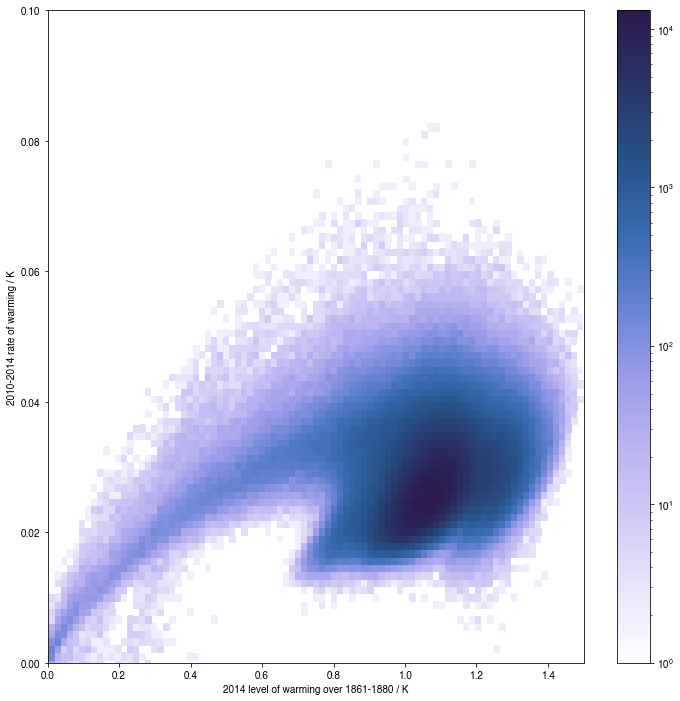

In [9]:
plt.figure(figsize=(12,12))
plt.hist2d(GWI_level_subsample,GWI_rate_subsample,bins=100,cmap=palettable.scientific.sequential.Devon_10_r.get_mpl_colormap(),norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlim(0,1.5)
plt.ylim(0,0.1)
plt.xlabel('2014 level of warming over 1861-1880 / K')
plt.ylabel('2010-2014 rate of warming / K')
print()

In [10]:
xy = np.vstack([GWI_level_subsample,GWI_rate_subsample])
sp_kde = sp.stats.gaussian_kde(xy)
X, Y = np.mgrid[0:1.5:100j, 0:0.1:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(sp_kde(positions).T, X.shape)

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Log scale: values of z <= 0 have been masked
  """
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Use the colorbar set_ticks() method instead.
  import sys


Text(0.5, 1.0, 'Constrained ensemble selection probability')

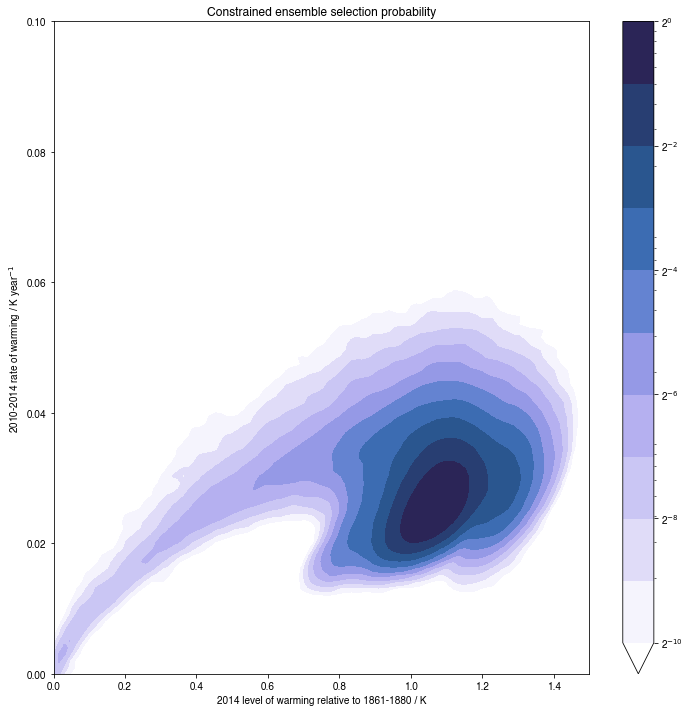

In [11]:
fig=plt.figure(figsize=(12,12))
# plt.scatter(*xy,c='r',zorder=10,s=0.001)

ytick_number = 11
plt.contourf(X,Y,Z/Z.max(),levels=[1/2**x for x in np.arange(ytick_number)[::-1]],norm=matplotlib.colors.LogNorm(),cmap=palettable.scientific.sequential.Devon_10_r.get_mpl_colormap(),extend='min')
cbar=plt.colorbar()
cbar.ax.set_yticks([1/2**x for x in np.arange(ytick_number)[::-1]])
cbar.ax.set_yticklabels([r"2$^{"+str(-x)+"}$" for x in np.arange(ytick_number)[::-2]])

plt.xlabel('2014 level of warming relative to 1861-1880 / K')
plt.ylabel('2010-2014 rate of warming / K year$^{-1}$')
plt.title('Constrained ensemble selection probability')

In [12]:
sp_kde_max = -1*sp.optimize.minimize(lambda x: -1*sp_kde(x),x0=[1,0.03],method='nelder-mead').fun

### Estimate GWI density

Times:

|members|time / s|
|---|---|
|1 |0.136|
|10|0.431|
|100|4.38|
|1000|44.7|

In [13]:
FULL_results = pd.read_hdf('../Parameter_Sets/NROY_GWI_informed/FULL_results.h5')

In [14]:
FULL_T_2014 = FULL_results.loc['T_2014'] - FULL_results.loc['T_baseline_1861_1880']
FULL_dt_2014 = FULL_results.loc['dT_2010_2014']

In [15]:
index_list = [FULL_T_2014.index[100*x:100*(x+1)] for x in np.arange(10000)]

In [16]:
def get_kde_probs(mems):
    print(mems[0],end='\r')
    return sp_kde(np.vstack([FULL_T_2014.loc[mems].values,FULL_dt_2014.loc[mems].values]))/sp_kde_max

In [17]:
import multiprocessing

In [18]:
P1 = multiprocessing.Pool(processes=6)
probability_NROY_select = P1.map(get_kde_probs,index_list)
P1.close()

In [19]:
FULL_probabilities = pd.concat([pd.Series(data=probability_NROY_select[i],index=index_list[i]) for i in np.arange(len(index_list))])

In [20]:
# FULL_probabilities.to_hdf(r'../Parameter_Sets/NROY_GWI_informed/FULL_member_selection_probabilities.h5', key='stage', mode='w')

# Part II: exploring the ensembles
Start here if using previously calculated ensemble member selection probabilities

In [2]:
## get FULL ensemble data
FULL_results = pd.read_hdf('../Parameter_Sets/NROY_GWI_informed/FULL_results.h5')
FULL_probabilities = pd.read_hdf('../Parameter_Sets/NROY_GWI_informed/FULL_member_selection_probabilities.h5')

### SSP data:

SSP_ids = [x.split('/')[-1].split('_')[0] for x in glob.glob('../Parameter_Sets/NROY_GWI_informed/SSP_results/*floating.h5')]
SSP_projections = []

for SSP in SSP_ids:
    SSP_projections += [pd.read_hdf('../Parameter_Sets/NROY_GWI_informed/SSP_results/'+SSP+'_floating.h5')]
    
SSP_projections = pd.concat(SSP_projections,keys=SSP_ids).reindex(FULL_results.columns,axis=1).sort_index(axis=0,level=0)

In [3]:
## create a boolean constraint series:

GWI_constraint = FULL_probabilities>np.random.random(FULL_probabilities.size)

## Key percentile statistics

In [4]:
## Present-day
choose_variables = ['ECS','TCR','carbon_dioxide_2019','methane_2019','nitrous_oxide_2019','other_wmghgs_2019','trop_o3_2019','strat_o3_2019','strat_h2o_2019','GHG_2019','ari_2019','aci_2019','aer_2019','bc_on_snow_2019','contrails_2019','anthro_2019']
pd.concat([FULL_results.loc[choose_variables].T.describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2),FULL_results.loc[choose_variables,GWI_constraint].T.describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2)],axis=1,keys=['FULL','CONSTRAINED'])

FULL                         CONSTRAINED              \
                       5% 16.6%   50% 83.3%   95%          5% 16.6%   50%   
ECS                  1.91  2.55  3.73  5.43  7.26        1.98  2.37  3.14   
TCR                  1.18  1.53  2.06  2.62  3.02        1.29  1.46  1.73   
carbon_dioxide_2019  1.62  1.80  2.08  2.37  2.58        1.68  1.86  2.12   
methane_2019         0.45  0.53  0.63  0.73  0.81        0.45  0.53  0.63   
nitrous_oxide_2019   0.16  0.18  0.20  0.22  0.24        0.16  0.18  0.20   
other_wmghgs_2019    0.29  0.32  0.36  0.40  0.43        0.29  0.32  0.36   
trop_o3_2019         0.20  0.28  0.40  0.51  0.60        0.20  0.28  0.40   
strat_o3_2019       -0.14 -0.10 -0.05  0.01  0.05       -0.14 -0.10 -0.04   
strat_h2o_2019       0.02  0.04  0.06  0.09  0.11        0.02  0.04  0.06   
GHG_2019             3.14  3.36  3.69  4.02  4.27        3.20  3.42  3.73   
ari_2019            -0.60 -0.47 -0.30 -0.15 -0.03       -0.58 -0.46 -0.31   
aci_2019            -2.28 -1.48 -0.70 -0.26 -0.05       -1.13 -0.86 -0.50   
aer_2019            -2.63 -1.81 -1.02 -0.53 -0.27       -1.45 -1.18 -0.83   
bc_on_snow_2019      0.04  0.05  0.09  0.13  0.18        0.04  0.05  0.08   
contrails_2019       0.01  0.02  0.04  0.06  0.07        0.01  0.02  0.04   
anthro_2019          0.87  1.71  2.58  3.21  3.62        2.09  2.39  2.82   

                                 
                    83.3%   95%  
ECS                  4.37  5.74  
TCR                  2.08  2.37  
carbon_dioxide_2019  2.40  2.60  
methane_2019         0.73  0.81  
nitrous_oxide_2019   0.22  0.24  
other_wmghgs_2019    0.40  0.43  
trop_o3_2019         0.51  0.59  
strat_o3_2019        0.01  0.05  
strat_h2o_2019       0.09  0.11  
GHG_2019             4.06  4.29  
ari_2019            -0.17 -0.06  
aci_2019            -0.22 -0.05  
aer_2019            -0.51 -0.31  
bc_on_snow_2019      0.13  0.18  
contrails_2019       0.06  0.07  
anthro_2019          3.26  3.57

In [5]:
## SSP projections
choose_variables = ['T_2100','anthro_2100']

pd.concat(\
    [pd.concat(\
    [(SSP_projections.xs('T_2100',level=1) - SSP_projections.xs('T_baseline_1861_1880',level=1)).T.describe([.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]],\
    (SSP_projections.xs('T_2100',level=1) - SSP_projections.xs('T_baseline_1861_1880',level=1)).loc[:,GWI_constraint].T.describe([.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]]],
    axis=1,keys=['FULL','CONSTRAINED']),\
    pd.concat(\
    [(SSP_projections.xs('anthro_2100',level=1)).T.describe([.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]],\
    (SSP_projections.xs('anthro_2100',level=1)).loc[:,GWI_constraint].T.describe([.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]]],
    axis=1,keys=['FULL','CONSTRAINED'])],\
axis=0,keys=['2100 warming relative to 1861-1880 / K','2100 anthropogenic ERF / W m$^{-2}$'])

FULL  \
                                                                        5%   
2100 warming relative to 1861-1880 / K ssp119                     0.747362   
                                       ssp126                     0.982069   
                                       ssp245                     1.549923   
                                       ssp370                     2.140289   
                                       ssp370-lowNTCF-aerchemmip  2.455307   
                                       ssp370-lowNTCF-gidden      2.056020   
                                       ssp434                     1.141066   
                                       ssp460                     1.784853   
                                       ssp534-over                1.133012   
                                       ssp585                     2.880173   
2100 anthropogenic ERF / W m$^{-2}$    ssp119                     1.692628   
                                       ssp126                     2.261270   
                                       ssp245                     3.705318   
                                       ssp370                     5.218545   
                                       ssp370-lowNTCF-aerchemmip  6.180989   
                                       ssp370-lowNTCF-gidden      5.111230   
                                       ssp434                     2.624737   
                                       ssp460                     4.311446   
                                       ssp534-over                2.499192   
                                       ssp585                     7.259120   

                                                                            \
                                                                     16.6%   
2100 warming relative to 1861-1880 / K ssp119                     1.019254   
                                       ssp126                     1.327713   
                                       ssp245                     2.079587   
                                       ssp370                     2.904782   
                                       ssp370-lowNTCF-aerchemmip  3.247994   
                                       ssp370-lowNTCF-gidden      2.739827   
                                       ssp434                     1.544093   
                                       ssp460                     2.382206   
                                       ssp534-over                1.539279   
                                       ssp585                     3.800464   
2100 anthropogenic ERF / W m$^{-2}$    ssp119                     1.887244   
                                       ssp126                     2.501696   
                                       ssp245                     4.131009   
                                       ssp370                     6.080871   
                                       ssp370-lowNTCF-aerchemmip  6.784257   
                                       ssp370-lowNTCF-gidden      5.699797   
                                       ssp434                     2.950825   
                                       ssp460                     4.797147   
                                       ssp534-over                2.778289   
                                       ssp585                     7.942088   

                                                                            \
                                                                       50%   
2100 warming relative to 1861-1880 / K ssp119                     1.489093   
                                       ssp126                     1.916963   
                                       ssp245                     2.968150   
                                       ssp370                     4.169840   
                                       ssp370-lowNTCF-aerchemmip  4.534596   
                                       ssp370-lowNTCF-gidden      3.862913   
            

## Climate sensitivity comparison

In [6]:
## get CMIP6 climate sensitivities

response_df = pd.read_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv',index_col=0)

def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    order = np.argsort(tau)
    
    return pd.DataFrame([tau[order],q[order]],index=['d','q'],columns=[1,2,3])

response_df.loc['ECS'] = np.nan
response_df.loc['TCR'] = np.nan
for model in response_df.columns:
    fair_params = pd.concat([convert_geoffrey_to_FaIR(response_df.loc[:'F_4x',model].values)],axis=1,keys=[model])
    response_df.loc[['ECS','TCR'],model] = q_to_tcr_ecs(fair_params,F_2x = response_df.loc['F_2x',model]).iloc[:,0]
response_df.loc['RWF'] = response_df.loc['TCR'] / response_df.loc['ECS']

# now calculate the Gregory-method effECS:

abrupt4xdata = pd.read_csv('../tools/cmip6_data/abrupt4x_tas_N_bias_corr.csv',header=[0,1],index_col=0)
for model in abrupt4xdata.columns.levels[0]:
    response_df.loc['effECS',model] = sp.stats.linregress(abrupt4xdata[model].loc[:149,'N'].dropna(),abrupt4xdata[model].loc[:149,'tas'].dropna()).intercept/2

In [7]:
clim_sens_comp = pd.DataFrame(columns=pd.MultiIndex.from_product([['ECS','TCR'],[5,17,50,83,95]]))

clim_sens_comp.loc['FULL','ECS'] = FULL_results.loc['ECS',:].quantile([.05,.166,.5,.833,.95]).values
clim_sens_comp.loc['FULL','TCR'] = FULL_results.loc['TCR',:].quantile([.05,.166,.5,.833,.95]).values

clim_sens_comp.loc['CONSTRAINED','ECS'] = FULL_results.loc['ECS',GWI_constraint].quantile([.05,.166,.5,.833,.95]).values
clim_sens_comp.loc['CONSTRAINED','TCR'] = FULL_results.loc['TCR',GWI_constraint].quantile([.05,.166,.5,.833,.95]).values

# clim_sens_comp.loc['ALTERNATIVE','ECS'] = [1.74,2.14,3.14,5.20,7.42]
# clim_sens_comp.loc['ALTERNATIVE','TCR'] = [1.15,1.34,1.69,2.14,2.54]

clim_sens_comp.loc['Njisse','ECS'] = [1.52,1.9,2.6,3.4,4.03]
clim_sens_comp.loc['Njisse','TCR'] = [1.0,1.29,1.68,2.05,2.3]

clim_sens_comp.loc['Tokarska','ECS'] = [np.nan]*5
clim_sens_comp.loc['Tokarska','TCR'] = [np.nan,1.2,1.6,1.99,np.nan]

clim_sens_comp.loc['JCM','ECS'] = [1.72,np.nan,2.83,np.nan,4.12]
clim_sens_comp.loc['JCM','TCR'] = [1.16,np.nan,1.67,np.nan,2.16]

clim_sens_comp.loc['Sherwood','ECS'] = [2.3,2.6,3.1,3.9,4.7]
clim_sens_comp.loc['Sherwood','TCR'] = [np.nan,1.5,1.8,2.2,np.nan]

clim_sens_comp.loc['Sherwood-robust','ECS'] = [2.0,2.3,np.nan,4.1,5.7]
clim_sens_comp.loc['Sherwood-robust','TCR'] = [np.nan]*5

## response_df

clim_sens_comp.loc['CMIP6','ECS'] = response_df.loc['ECS'].quantile([0.05,0.166,0.5,0.833,0.95]).values
clim_sens_comp.loc['CMIP6*','ECS'] = response_df.loc['effECS'].quantile([0.05,0.166,0.5,0.833,0.95]).values
clim_sens_comp.loc['CMIP6','TCR'] = response_df.loc['TCR'].quantile([0.05,0.166,0.5,0.833,0.95]).values

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  import sys
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'TCR / K')

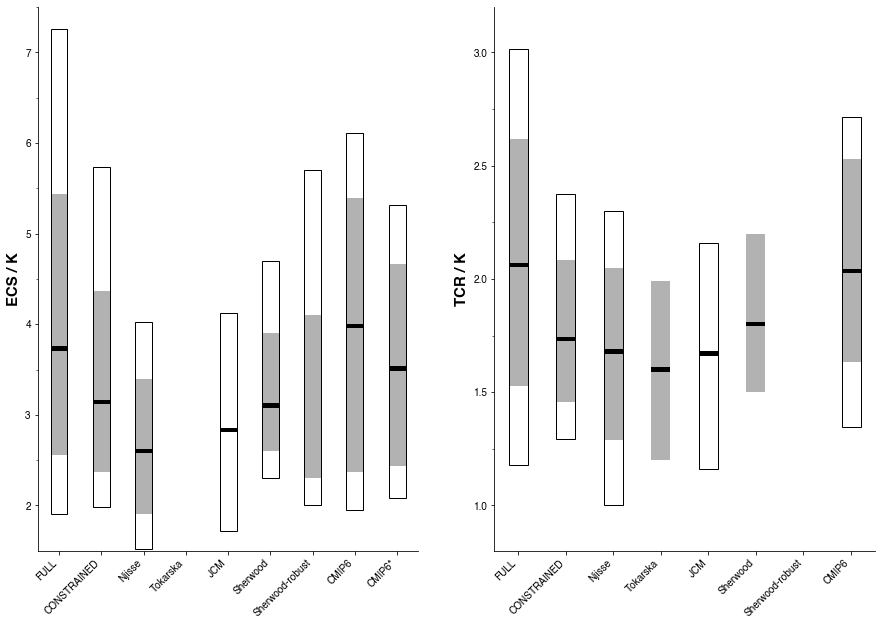

In [8]:
clim_sens_comp['ECS']

fig,ax = plt.subplots(1,2,figsize=(15,10))

for i,source in enumerate(clim_sens_comp.index):
    
    ax[0].bar(i,clim_sens_comp.loc[source,'ECS'][95]-clim_sens_comp.loc[source,'ECS'][5],0.4,clim_sens_comp.loc[source,'ECS'][5],color='',ec='k')
    ax[0].bar(i,clim_sens_comp.loc[source,'ECS'][83]-clim_sens_comp.loc[source,'ECS'][17],0.4,clim_sens_comp.loc[source,'ECS'][17],color='k',alpha=0.3)
    
    ax[1].bar(i,clim_sens_comp.loc[source,'TCR'][95]-clim_sens_comp.loc[source,'TCR'][5],0.4,clim_sens_comp.loc[source,'TCR'][5],color='',ec='k')
    ax[1].bar(i,clim_sens_comp.loc[source,'TCR'][83]-clim_sens_comp.loc[source,'TCR'][17],0.4,clim_sens_comp.loc[source,'TCR'][17],color='k',alpha=0.3)
    
    ax[0].bar(i,0.05,0.4,clim_sens_comp.loc[source,'ECS'][50]-0.025,color='k',)
    ax[1].bar(i,0.05*0.4,0.4,clim_sens_comp.loc[source,'TCR'][50]-0.025*0.4,color='k',)
    

[a.set_xticks(np.arange(clim_sens_comp.index.size)) for a in ax]
[a.set_xticklabels(clim_sens_comp.index,ha='right') for a in ax]
[a.tick_params(axis='x',rotation=45) for a in ax]

[a.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2)) for a in ax]

[a.spines[pos].set_visible(False) for a in ax for pos in ['right','top']]

ax[0].set_xlim(-0.5,clim_sens_comp.index.size-0.5)
ax[1].set_xlim(-0.5,clim_sens_comp.index.size-1.5)

ax[0].set_ylim(1.5,7.5)
ax[1].set_ylim(0.8,3.2)

ax[0].set_ylabel('ECS / K',fontweight='bold',fontsize=15)
ax[1].set_ylabel('TCR / K',fontweight='bold',fontsize=15)

# [fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/Clim_sens_comparison.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

## Corner plots

get CMIP6 data for comparison

In [9]:
## obtain some cmip6 parameter ranges for tas / ECS / TCR / aer_2019

## get the actual historical / ssp data:
ssp_tas = pd.read_csv('../tools/cmip6_data/ssp_tas.csv',index_col=0)
hist_tas = pd.read_csv('../tools/cmip6_data/hist_tas.csv',index_col=0).iloc[1:]

for i,x in enumerate(['source','member','variable','experiment']):
    ssp_tas.loc[x] = [x.split('_')[i+1] for x in ssp_tas.columns]
for i,x in enumerate(['source','member']):    
    hist_tas.loc[x] = [x.split('_')[i+1] for x in hist_tas.columns]
    

ssp_tas=ssp_tas.T.set_index(['source','member','experiment']).T.drop('variable').apply(pd.to_numeric)
hist_tas=hist_tas.T.set_index(['source','member']).T.apply(pd.to_numeric)
ssp_tas['year']=[int(x) for x in ssp_tas.index]
ssp_tas = ssp_tas.set_index('year')
ssp_tas = ssp_tas.reindex(np.arange(1850,2301))

hist_tas['year']=[int(x) for x in hist_tas.index]
hist_tas = hist_tas.set_index('year')

for modmem in hist_tas.columns:
    if modmem in ssp_tas.columns.droplevel(-1):
        for exp in ssp_tas.loc[1850:2014,modmem].columns:
            ssp_tas.loc[1850:2014,(*modmem,exp)] = hist_tas.loc[1850:2014,modmem]
            
baseline = [1861,1880]

plot_cmip6_tas2100 = ssp_tas.loc[:].xs('ssp245',axis=1,level=-1).drop(('KACE-1-0-G','r3i1p1f1'),axis=1).groupby(level=0,axis=1).mean()
plot_cmip6_tas2100 = plot_cmip6_tas2100 - plot_cmip6_tas2100.loc[baseline[0]:baseline[1]].mean()

plot_cmip6_dT_10s = plot_cmip6_tas2100.loc[2010:2019].apply(lambda x:sp.stats.linregress(np.arange(10),x).slope)*10

# ERFari/aci: APRP data very noisy so we use the emissions based fits:
ERFari_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFari.csv',index_col=0)
ERFaci_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFaci.csv',index_col=0)

ssp_emms = RCMIP_to_GIR_input_emms('ssp245').interpolate().reindex(np.arange(1750,2101))
ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values

CMIP6_aer_forc_2019 = pd.DataFrame(index=ERFari_params.index,columns=['aci','ari','aer'])

for model in CMIP6_aer_forc_2019.index:
    CMIP6_aer_forc_2019.loc[model,'ari'] = ssp_emms.loc[2019,'so2']*ERFari_params.loc[model,'so2'] + ssp_emms.loc[2019,'bc']*ERFari_params.loc[model,'bc'] + ssp_emms.loc[2019,'oc']*ERFari_params.loc[model,'oc']
    CMIP6_aer_forc_2019.loc[model,'aci'] = ERFaci_params.loc[model,'beta'] * np.log(1+ssp_emms.loc[2019,'so2']/ERFaci_params.loc[model,'s']) + ERFaci_params.loc[model,'alpha']*(ssp_emms.loc[2019,'bc']+ssp_emms.loc[2019,'oc'])
    CMIP6_aer_forc_2019.loc[model,'aer'] = CMIP6_aer_forc_2019.loc[model,'aci'] + CMIP6_aer_forc_2019.loc[model,'ari']

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


definition to compute the density contours

In [47]:
def custom_kde(x,y):

    ## first remove the FAR outliers (>0.1%) from x and y in turn as they insignificantly affect the contours and ruin the script

    x_cutoff_low = np.quantile(x,0.001)
    x_cutoff_high = np.quantile(x,0.999)
    y_cutoff_low = np.quantile(y,0.001)
    y_cutoff_high = np.quantile(y,0.999)

    x_rank = np.argsort(x)
    x = x[x_rank]
    y = y[x_rank]
    num_outlier_high = -1*((x>x_cutoff_high).sum())
    num_outlier_low = (x<(x_cutoff_low)).sum()
    if not num_outlier_high:
        num_outlier_high = None
    if not num_outlier_low:
        num_outlier_low = None
    x = x[num_outlier_low:num_outlier_high]
    y = y[num_outlier_low:num_outlier_high]


    y_rank = np.argsort(y)
    x = x[y_rank]
    y = y[y_rank]
    num_outlier_high = -1*((y>y_cutoff_high).sum())
    num_outlier_low = (y<(y_cutoff_low)).sum()
    if not num_outlier_high:
        num_outlier_high = None
    if not num_outlier_low:
        num_outlier_low = None
    x = x[num_outlier_low:num_outlier_high]
    y = y[num_outlier_low:num_outlier_high]

    gridsize=100
    k = sp.stats.kde.gaussian_kde([x,y])
    xi,yi = np.mgrid[x.min()-0.5:x.max()+0.5:gridsize*1j,y.min()-0.5:y.max()+0.5:gridsize*1j]
    zi = k(np.vstack([xi.flatten(),yi.flatten()])).reshape(xi.shape)
    dens_vals = np.linspace(0,zi.max(),gridsize)
    zi_int = ((zi>=dens_vals[:,None,None])*zi).sum(axis=(1,2))/zi.sum()
    zi_int_to_dens = sp.interpolate.interp1d(zi_int,dens_vals)
    dens_contours = zi_int_to_dens([0.95,0.67,0.33,0.05])
    
    return xi,yi,zi,dens_contours

clean data prior to plotting

In [48]:
## create neat dataframe for FULL / constrained corner plot:

corner_plot_data = FULL_results.loc[['ECS','TCR','T_10s','T_EoC','aer_2019','anthro_2019'],:].copy()
corner_plot_data.loc['dT_10s'] = SSP_projections.loc[('ssp245','dT_2010_2019')]*10
for var in ['T_10s','T_EoC']:
    corner_plot_data.loc[var] -= FULL_results.loc['T_baseline_1861_1880',:]

draw the corner plot

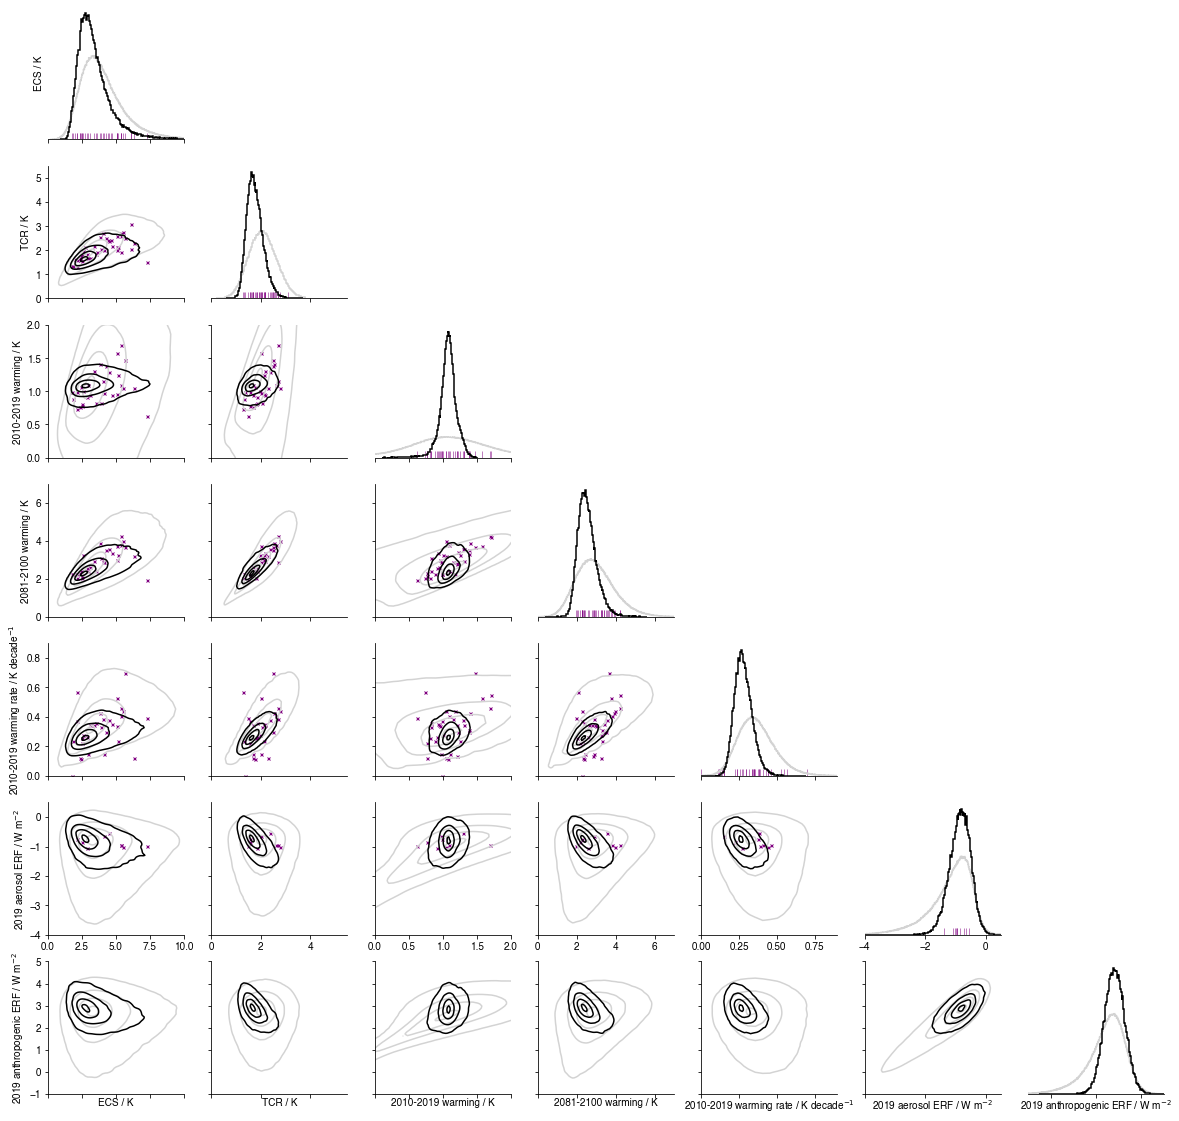

In [55]:
## create a correlation matrix plot:

cor_vars = ['ECS','TCR','T_10s','T_EoC','dT_10s','aer_2019','anthro_2019']

map_cor_vars = dict(zip(cor_vars,['ECS / K','TCR / K','2010-2019 warming / K','2081-2100 warming / K','2010-2019 warming rate / K decade$^{-1}$','2019 aerosol ERF / W m$^{-2}$','2019 anthropogenic ERF / W m$^{-2}$']))

fig,ax = plt.subplots(len(cor_vars),len(cor_vars),figsize=(20,20))

[ax[i,j].set_visible(False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j>i]

## plot the distributions:

for i in np.arange(len(cor_vars)):
    ax[i,i].hist(corner_plot_data.loc[cor_vars[i]].values.flatten(),histtype='step',color='lightgrey',density=True,lw=1.5)
#     ax[i,i].hist(corner_plot_data.loc[cor_vars[i],FULL_results.loc['constrain_level'].astype(bool)].values.flatten(),histtype='step',color='red',density=True,lw=1.5,alpha=0.3)
    ax[i,i].hist(corner_plot_data.loc[cor_vars[i],GWI_constraint].values.flatten(),histtype='step',color='k',density=True,lw=1.5)
    
    
## do some kde plots
import multiprocessing
def kde_wrapper(i,j,constrain):
    if constrain:
        result = custom_kde(corner_plot_data.loc[cor_vars[j],GWI_constraint].values.flatten(),corner_plot_data.loc[cor_vars[i],GWI_constraint].values.flatten())
    else:
        result = custom_kde(corner_plot_data.loc[cor_vars[j]].values.flatten(),corner_plot_data.loc[cor_vars[i]].values.flatten())
        
    return result
        
# derive the kdes:
        
# P1=multiprocessing.Pool(processes=4)
plot_indices = [[i,j,False] for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
# kde_FULL = P1.starmap(kde_wrapper,plot_indices)
# # plot_indices = [[i,j,'constrain_level'] for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
# # kde_level = P1.starmap(kde_wrapper,plot_indices)
# plot_indices = [[i,j,True] for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
# kde_constrain = P1.starmap(kde_wrapper,plot_indices)
# P1.close()

# plot the kdes:
[ax[x[0],x[1]].contour(kde_FULL[i][0],kde_FULL[i][1],kde_FULL[i][2],kde_FULL[i][3],colors='lightgrey') for i,x in enumerate(plot_indices)]
# [ax[x[0],x[1]].contour(kde_level[i][0],kde_level[i][1],kde_level[i][2],kde_level[i][3],colors='red',alpha=0.3) for i,x in enumerate(plot_indices)]
[ax[x[0],x[1]].contour(kde_constrain[i][0],kde_constrain[i][1],kde_constrain[i][2],kde_constrain[i][3],colors='k') for i,x in enumerate(plot_indices)]

# plot CMIP6 samples:
cmip6_samples = [response_df.loc['ECS'],response_df.loc['TCR'],plot_cmip6_tas2100.loc[2010:2019].mean(),plot_cmip6_tas2100.loc[2081:2100].mean(),plot_cmip6_dT_10s,CMIP6_aer_forc_2019.aer]
for i in np.arange(6):
    for j in np.arange(6):
        if j<i:
            intersection = list(set(cmip6_samples[i].index).intersection(set(cmip6_samples[j].index)))
            ax[i,j].plot(cmip6_samples[j].loc[intersection],cmip6_samples[i].loc[intersection],'x',color='purple',ms=3,zorder=0)

axes_lims = [[0,10],[0,5.5],[0,2],[0,7],[0,0.9],[-4,0.5],[-1,5]]

[sn.rugplot(cmip6_samples[i],ax=ax[i,i],color='purple',lw=0.5) for i in np.arange(6)]

[ax[i,j].set_xlim(axes_lims[j]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars))]
[ax[i,j].set_ylim(axes_lims[i]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
[ax[i,j].set_ylabel(map_cor_vars[cor_vars[i]]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j==0]
[ax[i,j].set_xlabel(map_cor_vars[cor_vars[j]]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if i==6]

## diagonal axes
[ax[i,i].spines[pos].set_visible(False) for i in np.arange(len(cor_vars)) for pos in ['top','right','left']]
[ax[i,i].tick_params(left=False,labelleft=False) for i in np.arange(len(cor_vars))]

[ax[i,j].spines[pos].set_visible(False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) for pos in ['top','right']]
[ax[i,j].tick_params(labelleft=False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j!=0]
[ax[i,j].tick_params(labelbottom=False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if i!=6]
print()

## ALTERNATIVE distribution